In [1]:
from utils import Logger,adjust_learning_rate,CreateLogger,create_cosine_learning_schedule,encode_test_label,set_seed
from model import Resnet_with_uncertainty, MLP_with_uncertainty#不确定度
from dependency import *
from torch import optim
from torchcontrib.optim import SWA
from dataloader import generate_dataloader
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error # 均方误差
from tensorflow.keras.utils import to_categorical
import pandas as pd
from dependency import *
%matplotlib notebook

In [2]:
from model import Resnet_with_uncertainty,MyCNN,ResNet50_uncertainty,MLP_with_uncertainty
from second_stage_fusion_utils_concat2 import predict,predict3
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error 
import numpy as np
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib notebook

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:05<00:00, 71.51it/s]


In [3]:
import torch.nn.functional as F
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import roc_auc_score,accuracy_score, roc_curve,auc,average_precision_score,precision_recall_curve
import cv2
from dependency import *
import pandas as pd
from utils import encode_test_label,Logger,encode_meta_choosed_label,encode_meta_label
from tqdm import tqdm_notebook  

test_index_df = pd.read_csv(test_index_path)
train_index_df = pd.read_csv(train_index_path)
val_index_df = pd.read_csv(val_index_path)

train_index_list = list(train_index_df['indexes'])
val_index_list = list(val_index_df['indexes'])
test_index_list = list(test_index_df['indexes'])

train_index_list_1 = train_index_list[0:206]
train_index_list_2 = train_index_list[206:]

df = pd.read_csv(img_info_path)

In [4]:
def get_label_list(image_index_list):
    diag_label_list = []
    pn_label_list = []
    str_label_list = []
    pig_label_list = []
    rs_label_list = []
    dag_label_list = []
    bwv_label_list = []
    vs_label_list = []
    meta_list = []
    meta_list_one_hot = []
    
    img_feature = []
    img_hf_feature = []
    img_vf_feature = []
    img_vhf_feature = []

    from sklearn.decomposition import PCA

    from tqdm import tqdm_notebook,tqdm
    for index_num in tqdm(image_index_list):
    #index_num = test_index_list[100]
        img_info = df[index_num:index_num+1]
        clinic_path = img_info['clinic']
        dermoscopy_path = img_info['derm']
        source_dir = '../release_v0/release_v0/images/'
        clinic_img = cv2.imread(source_dir+clinic_path[index_num])
        dermoscopy_img = cv2.imread(source_dir+dermoscopy_path[index_num])
        '''这里对于metadata需要变更'''
        meta_vector_one_hot,meta_vector = encode_meta_choosed_label(img_info,index_num)
        
        [diagnosis_label,pigment_network_label,streaks_label,pigmentation_label,regression_structures_label,
         dots_and_globules_label,blue_whitish_veil_label, vascular_structures_label],[diagnosis_label_one_hot,pigment_network_label_one_hot,
        streaks_label_one_hot,pigmentation_label_one_hot,regression_structures_label_one_hot,
        dots_and_globules_label_one_hot,blue_whitish_veil_label_one_hot, vascular_structures_label_one_hot] = encode_test_label(img_info,index_num)

        diag_label_list.append(diagnosis_label)
        pn_label_list.append(pigment_network_label)
        str_label_list.append(streaks_label)
        pig_label_list.append(pigmentation_label)
        rs_label_list.append(regression_structures_label)
        dag_label_list.append(dots_and_globules_label)
        bwv_label_list.append(blue_whitish_veil_label)
        vs_label_list.append(vascular_structures_label)
        meta_list.append(meta_vector)
        meta_list_one_hot.append(meta_vector_one_hot)



    label_dict ={'diag':diag_label_list,
                 'pn':pn_label_list,
                 'str':str_label_list,
                 'pig':pig_label_list,
                 'rs':rs_label_list,
                 'dag':dag_label_list,
                 'bwv':bwv_label_list,
                 'vs':vs_label_list}
    
    return label_dict,meta_list,meta_list_one_hot

# multi-modality without uncertainty(derm, clinic, and metadata) fusion here

./multimodal_Resnet_cos-loss and concat-without uncertainty_Normal_weight_file/4/checkpoint/best_mean_acc_model.pth
./multimodal_MLP_without-uncertainty_Normal_weight_file/4/checkpoint/best_mean_acc_model.pth
P1--------------------------------on images

--- [START IDENTIFIER] ----------------------------------------------------------------




100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:39<00:00, 10.08it/s]
E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:1253: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_diag_sk = Tp_diag_sk / (Tp_diag_sk + Fp_diag_sk)


---------------

avg_acc : 0.7443037974683545

vs_acc : 0.8050632911392405

bwv_acc : 0.8734177215189873

dag_acc : 0.6075949367088608

rs_acc : 0.8075949367088607

pig_acc : 0.6987341772151898

str_acc : 0.7316455696202532

pn_acc : 0.7012658227848101

diag_acc : 0.7291139240506329

Diag-------------------------

nevu_SEN: 0.8904109589041096, SPE: 0.7329545454545454, PRE: 0.8057851239669421
bcc SEN: 0.3125, SPE: 0.9656992084432717, PRE: 0.2777777777777778
mel SEN: 0.6435643564356436, SPE: 0.8775510204081632, PRE: 0.6435643564356436
misc SEN: 0.575, SPE: 0.9690140845070423, PRE: 0.6764705882352942
sk SEN: 0.0, SPE: 1.0, PRE: nan
----------

pn_asb SEN: 0.8141025641025641, SPE: 0.8410041841004184, PRE: 0.7696969696969697
pn_typ SEN: 0.7534246575342466, SPE: 0.7991967871485943, PRE: 0.6875
pn_aty SEN: 0.43010752688172044, SPE: 0.9006622516556292, PRE: 0.5714285714285714
----------

str_asb SEN: 0.867704280155642, SPE: 0.5869565217391305, PRE: 0.7964285714285714
str_reg SEN: 0.52272727272

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:42<00:00,  9.32it/s]
E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:1240: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_vs_irg = Tp_vs_irg / (Tp_vs_irg + Fp_vs_irg)
E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:1253: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_diag_sk = Tp_diag_sk / (Tp_diag_sk + Fp_diag_sk)


---------------

avg_acc : 0.7594936708860759

vs_acc : 0.810126582278481

bwv_acc : 0.8911392405063291

dag_acc : 0.6582278481012658

rs_acc : 0.789873417721519

pig_acc : 0.7012658227848101

str_acc : 0.7417721518987341

pn_acc : 0.7139240506329114

diag_acc : 0.769620253164557

Diag-------------------------

nevu_SEN: 0.9178082191780822, SPE: 0.7215909090909091, PRE: 0.804
bcc SEN: 0.5625, SPE: 0.9683377308707124, PRE: 0.42857142857142855
mel SEN: 0.6732673267326733, SPE: 0.9217687074829932, PRE: 0.7472527472527473
misc SEN: 0.65, SPE: 0.9802816901408451, PRE: 0.7878787878787878
sk SEN: 0.0, SPE: 1.0, PRE: nan
----------

pn_asb SEN: 0.8269230769230769, SPE: 0.799163179916318, PRE: 0.7288135593220338
pn_typ SEN: 0.7602739726027398, SPE: 0.8473895582329317, PRE: 0.7449664429530202
pn_aty SEN: 0.45161290322580644, SPE: 0.9105960264900662, PRE: 0.6086956521739131
----------

str_asb SEN: 0.914396887159533, SPE: 0.47101449275362317, PRE: 0.762987012987013
str_reg SEN: 0.2954545454545454

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:43<00:00,  9.09it/s]


<IPython.core.display.Javascript object>


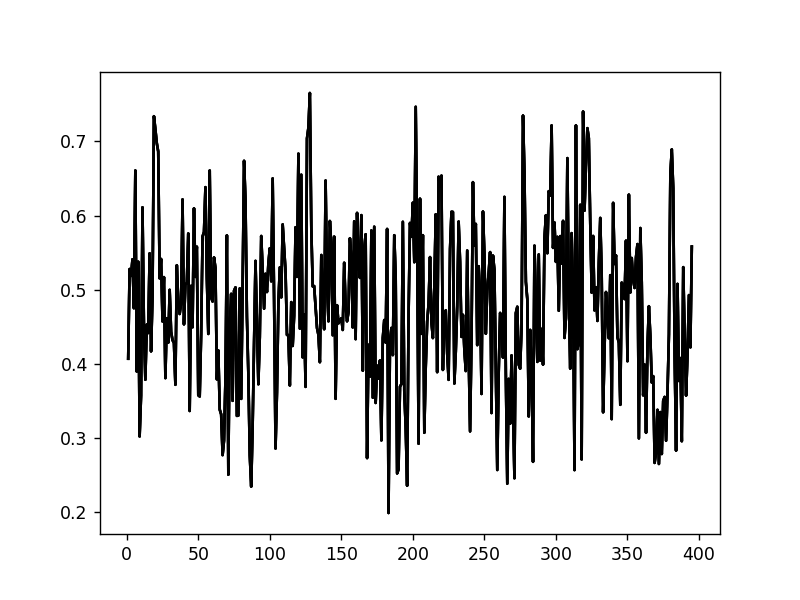

E:\university\my_project\metadata_analysis\模态融合—置信度判断\uncertainty model\second_stage_fusion_utils_concat2.py:2583: RuntimeWarning: invalid value encountered in longlong_scalars
  PRE_vs_irg = Tp_vs_irg / (Tp_vs_irg + Fp_vs_irg)


---------------

avg_acc : 0.7591772151898735

vs_acc : 0.8177215189873418

bwv_acc : 0.8810126582278481

dag_acc : 0.6329113924050633

rs_acc : 0.8177215189873418

pig_acc : 0.6987341772151898

str_acc : 0.7341772151898734

pn_acc : 0.7215189873417721

diag_acc : 0.769620253164557

Diag-------------------------

nevu_SEN: 0.9178082191780822, SPE: 0.7329545454545454, PRE: 0.8104838709677419
bcc SEN: 0.5625, SPE: 0.9709762532981531, PRE: 0.45
mel SEN: 0.6633663366336634, SPE: 0.9149659863945578, PRE: 0.7282608695652174
misc SEN: 0.65, SPE: 0.9774647887323944, PRE: 0.7647058823529411
sk SEN: 0.05263157894736842, SPE: 1.0, PRE: 1.0
----------

pn_asb SEN: 0.8397435897435898, SPE: 0.8075313807531381, PRE: 0.7401129943502824
pn_typ SEN: 0.7602739726027398, SPE: 0.8353413654618473, PRE: 0.7302631578947368
pn_aty SEN: 0.46236559139784944, SPE: 0.9238410596026491, PRE: 0.6515151515151515
----------

str_asb SEN: 0.9066147859922179, SPE: 0.4782608695652174, PRE: 0.7639344262295082
str_reg SEN: 

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:44<00:00,  8.80it/s]


---------------

avg_acc : 0.7542721518987343

vs_acc : 0.8113924050632911

bwv_acc : 0.8784810126582279

dag_acc : 0.6316455696202532

rs_acc : 0.8075949367088607

pig_acc : 0.7

str_acc : 0.7354430379746836

pn_acc : 0.7164556962025317

diag_acc : 0.7531645569620253

Diag-------------------------

nevu_SEN: 0.908675799086758, SPE: 0.7130681818181818, PRE: 0.7975951903807615
bcc SEN: 0.53125, SPE: 0.9696569920844327, PRE: 0.425
mel SEN: 0.6534653465346535, SPE: 0.9081632653061225, PRE: 0.7096774193548387
misc SEN: 0.5875, SPE: 0.976056338028169, PRE: 0.734375
sk SEN: 0.02631578947368421, SPE: 1.0, PRE: 1.0
----------

pn_asb SEN: 0.842948717948718, SPE: 0.8075313807531381, PRE: 0.7408450704225352
pn_typ SEN: 0.7636986301369864, SPE: 0.8232931726907631, PRE: 0.7170418006430869
pn_aty SEN: 0.43010752688172044, SPE: 0.9271523178807947, PRE: 0.6451612903225806
----------

str_asb SEN: 0.9027237354085603, SPE: 0.5036231884057971, PRE: 0.7720465890183028
str_reg SEN: 0.38636363636363635, SP

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:45<00:00,  8.63it/s]


---------------

avg_acc : 0.7553797468354431

vs_acc : 0.8135021097046413

bwv_acc : 0.8784810126582279

dag_acc : 0.6320675105485232

rs_acc : 0.8118143459915612

pig_acc : 0.6962025316455697

str_acc : 0.7333333333333333

pn_acc : 0.7215189873417721

diag_acc : 0.7561181434599156

Diag-------------------------

nevu_SEN: 0.9117199391171994, SPE: 0.7140151515151515, PRE: 0.7986666666666666
bcc SEN: 0.5416666666666666, SPE: 0.9700967458223395, PRE: 0.43333333333333335
mel SEN: 0.6501650165016502, SPE: 0.9104308390022676, PRE: 0.7137681159420289
misc SEN: 0.6, SPE: 0.9765258215962441, PRE: 0.7422680412371134
sk SEN: 0.03508771929824561, SPE: 1.0, PRE: 1.0
----------

pn_asb SEN: 0.8461538461538461, SPE: 0.8089260808926081, PRE: 0.7429643527204502
pn_typ SEN: 0.7671232876712328, SPE: 0.8286479250334672, PRE: 0.7241379310344828
pn_aty SEN: 0.44086021505376344, SPE: 0.9282560706401766, PRE: 0.6542553191489362
----------

str_asb SEN: 0.9014267185473411, SPE: 0.4975845410628019, PRE: 0.769

In [9]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
seed = 0
mode = 'multimodal'
model_name = 'Resnet_cos-loss and concat-without uncertainty'
import random
random.seed(seed)
TTA = 6
img_type="concat"
size = 229
data_mode = 'Normal'

#change i here!
i = 4

p1_acc_list = []
p2_acc_list = []
p3_acc_list = []

mean_avg_acc_list = []

weight_file = './{}_{}_{}_weight_file/{}/checkpoint/best_mean_acc_model.pth'.format(mode,model_name,data_mode,i)
print(weight_file)

net = Resnet_with_uncertainty(class_list).cuda()
net.load_state_dict(torch.load(weight_file))

weight_file2 = './{}_{}_{}_weight_file/{}/checkpoint/best_mean_acc_model.pth'.format("multimodal","MLP_without-uncertainty",data_mode,i)
print(weight_file2)

net2 =  MLP_with_uncertainty(class_list).cuda()

net2.load_state_dict(torch.load(weight_file2))
print("P1--------------------------------on images")
out_dir = './{}_{}_result/{}/'.format(mode,model_name,"P1")
(avg_acc,uncertainty_pred,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict(net2,net,test_index_list,df,
                                                                    model_name,out_dir,mode,TTA,size,img_type,"img")
print("P2--------------------------------on metadata")
out_dir = './{}_{}_result/{}/'.format("multimodal","MLP","P2")
(avg_acc,uncertainty_pred,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict(net2,net,test_index_list,df,
                                                                    model_name,out_dir,mode,TTA,size,img_type,"metadata")
prob_2 = prob
pn_prob_2 = pn_prob
str_prob_2 = str_prob
pig_prob_2 = pig_prob
rs_prob_2 = rs_prob
dag_prob_2 = dag_prob
bwv_prob_2 = bwv_prob
vs_prob_2 = vs_prob
uncertainty_2 = uncertainty_pred
p2_list  = [prob_2,pn_prob_2,str_prob_2,pig_prob_2,rs_prob_2,dag_prob_2,bwv_prob_2,vs_prob_2,uncertainty_2]
print("P2 Done")

print("(clinic, derm)-concat & metadata fusion here!------------------------------------------------")
out_dir = './{}_{}_result/{}/'.format(mode,model_name,"P3")
(avg_acc,
     [prob,pn_prob,str_prob,pig_prob,rs_prob,dag_prob,bwv_prob,vs_prob], 
     [nevu_label, bcc_label, mel_label, misc_label, sk_label],
     [nevu_prob ,bcc_prob ,  mel_prob ,misc_prob ,sk_prob],
     seven_point_feature_list,
     [gt,pn_gt,str_gt,pig_gt,rs_gt,dag_gt, bwv_gt,vs_gt] )= predict3(net,net2,test_index_list,df,model_name,out_dir,mode,TTA,size,img_type)